In [1]:
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV, cross_val_predict, cross_val_score, StratifiedKFold
from sklearn.dummy import DummyClassifier
from sklearn.base import clone
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, roc_curve, precision_recall_curve, f1_score, confusion_matrix, precision_score, recall_score
import numpy as np
import matplotlib.patches as patches
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multioutput import ClassifierChain
from sklearn.pipeline import Pipeline
import pandas as pd
from scipy.ndimage.interpolation import shift


/tmp/ipykernel_241118/3558433363.py:18: DeprecationWarning: Please use `shift` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import shift


In [2]:
mnist = fetch_openml("mnist_784", as_frame=False)

/home/kraiser/miniconda3/envs/DL/lib/python3.9/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [3]:
X, y = mnist.data, mnist.target

In [4]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [5]:
X.shape

(70000, 784)

In [6]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [7]:
y.shape

(70000,)

In [8]:
def plot_digit(image_data):
  image = image_data.reshape(28, 28)
  plt.imshow(image, cmap="binary")
  plt.axis("off")

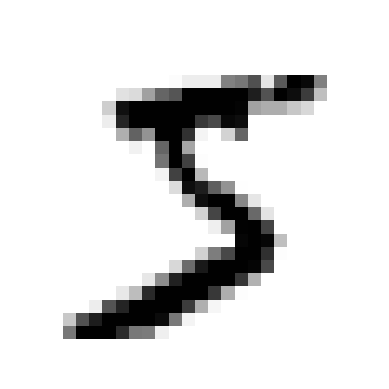

In [9]:
some_digit = X[0]
plot_digit(some_digit)

In [10]:
y[0]

'5'

In [11]:
more_digit = X[:20]
more_digit_labels = y[:20]

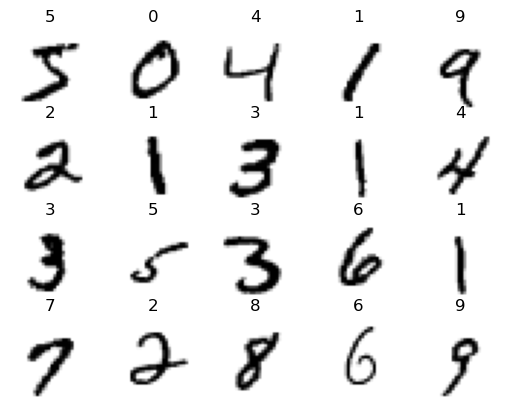

In [12]:
for i in range(20):
  plt.subplot(4, 5, i+1)
  plot_digit(more_digit[i])
  plt.title(more_digit_labels[i])

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [14]:
X_test.shape

(10000, 784)

In [15]:
y_train_5 = (y_train == "5")
y_test_5 = (y_test == "5")

In [16]:
y_train_5

array([ True, False, False, ...,  True, False, False])

In [17]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [18]:
sgd_clf.predict([some_digit])

array([ True])

In [19]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [20]:
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train)))

False


In [21]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

In [22]:
skfolds = StratifiedKFold(n_splits=3)
for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf = clone(sgd_clf)
  X_train_folds = X_train[train_index]
  y_train_folds = y_train_5[train_index]
  X_test_fold = X_train[test_index]
  y_test_fold = y_train_5[test_index]

  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred = clone_clf.predict(X_test_fold)
  n_correct = sum(y_pred == y_test_fold)
  print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


In [23]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [24]:
y_train_pred

array([ True, False, False, ...,  True, False, False])

In [25]:
cm = confusion_matrix(y_train_5, y_train_pred)

In [26]:
cm

array([[53892,   687],
       [ 1891,  3530]])

In [27]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

In [28]:
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [29]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [30]:
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [31]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [32]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [33]:
y_some_digit_pred

array([ True])

In [34]:
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [35]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                            method="decision_function")

In [36]:
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [37]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

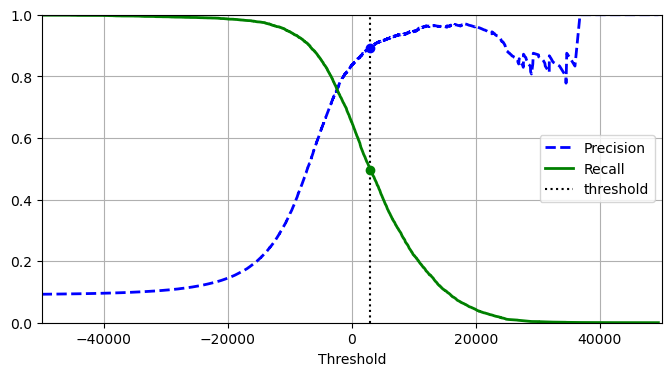

In [38]:
plt.figure(figsize=(8, 4))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")

idx = (thresholds >= threshold).argmax()
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-50000, 50000, 0, 1])
plt.legend(loc="center right")
plt.xlabel("Threshold")
plt.grid()

In [39]:
recalls[idx], precisions[idx]

(0.4967718133185759, 0.8911317008603574)

Text(0, 0.5, 'Precision')

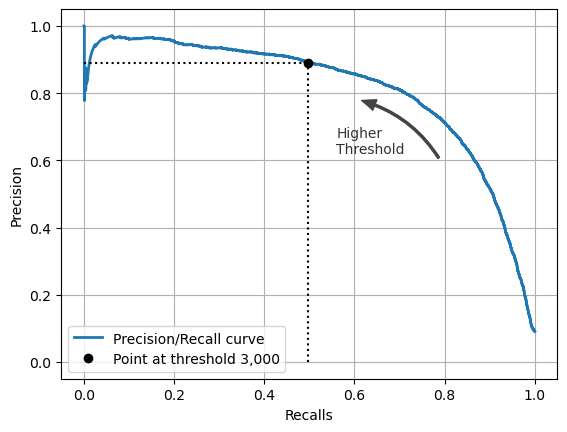

In [40]:
plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")
plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0., recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko", label="Point at threshold 3,000")

plt.gca().add_patch(patches.FancyArrowPatch(
  (0.79, 0.60), (0.61, 0.78),
  connectionstyle="arc3,rad=.2",
  arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
  color="#444444"
))
plt.text(0.56, 0.62, "Higher\nThreshold", color="#333333")

plt.legend(loc="lower left")
plt.grid()
plt.xlabel("Recalls")
plt.ylabel("Precision")

In [41]:
idx_for_90_precision = (precisions >= 0.90).argmax()
idx_for_90_precision

57109

In [42]:
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

3370.0194991439557

In [43]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

In [44]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [45]:
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)
recall_at_90_precision

0.4799852425751706

In [46]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [47]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

Text(0, 0.5, 'True Positive Rate (Recall)')

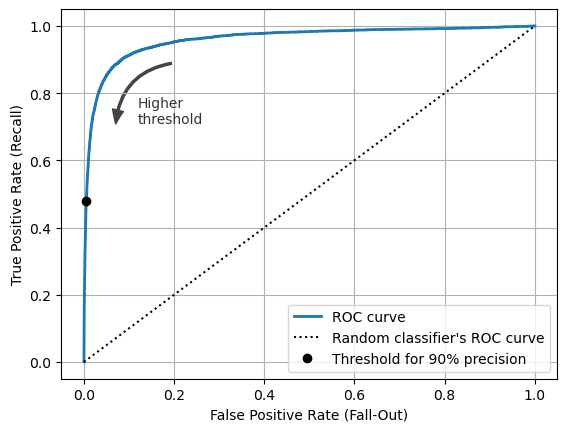

In [48]:
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0., 1.], [0., 1.], "k:", label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")

plt.gca().add_patch(patches.FancyArrowPatch(
  (0.20, 0.89), (0.07, 0.70),
  connectionstyle="arc3,rad=.4",
  arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
  color="#444444"
))
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")

plt.legend()
plt.grid()
plt.xlabel("False Positive Rate (Fall-Out)")
plt.ylabel("True Positive Rate (Recall)")

In [49]:
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [50]:
forest_clf = RandomForestClassifier(random_state=42)

In [51]:
y_proba_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                  method="predict_proba")

In [52]:
y_proba_forest[:5]

array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       [1.  , 0.  ],
       [0.99, 0.01]])

In [53]:
y_scores_forest = y_proba_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(
  y_train_5, y_scores_forest
)

Text(0, 0.5, 'Precision')

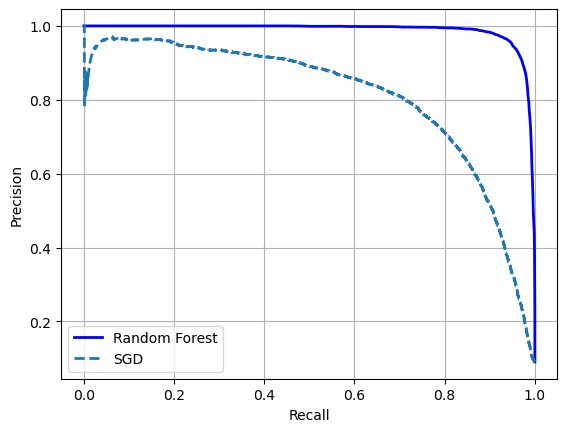

In [54]:
plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2, label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")

plt.legend()
plt.grid()
plt.xlabel("Recall")
plt.ylabel("Precision")

In [55]:
y_train_pred_forest = y_proba_forest[:, 1] >= 0.5
f1_score(y_train_5, y_train_pred_forest)

0.9274509803921569

In [56]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [57]:
precision_score(y_train_5, y_train_pred_forest)

0.9897468089558485

In [58]:
recall_score(y_train_5, y_train_pred_forest)

0.8725327430363402

In [59]:
svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000])

SVC(random_state=42)

In [60]:
svm_clf.predict([some_digit])

array(['5'], dtype=object)

In [61]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores.round(2)

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

In [62]:
class_id = some_digit_scores.argmax()
class_id

5

In [63]:
svm_clf.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [64]:
svm_clf.classes_[class_id]

'5'

In [65]:
ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

In [66]:
ovr_clf.predict([some_digit])

array(['5'], dtype='<U1')

In [67]:
len(ovr_clf.estimators_)

10

In [68]:
ovr_clf.estimators_

[SVC(random_state=42),
 SVC(random_state=42),
 SVC(random_state=42),
 SVC(random_state=42),
 SVC(random_state=42),
 SVC(random_state=42),
 SVC(random_state=42),
 SVC(random_state=42),
 SVC(random_state=42),
 SVC(random_state=42)]

In [81]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)

SGDClassifier(random_state=42)

In [82]:
sgd_clf.predict([some_digit])

array(['3'], dtype='<U1')

In [83]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [84]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [85]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype("float64"))
cross_val_score(sgd_clf, X_train_scaled, y_train,
               cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

In [86]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

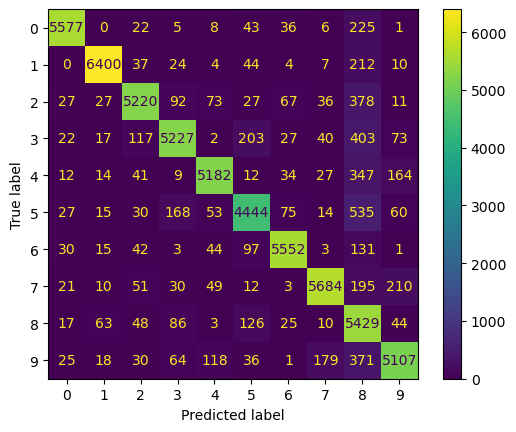

In [87]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)

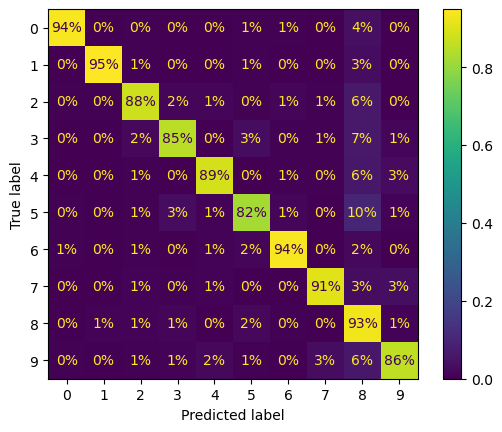

In [88]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                       normalize="true", values_format=".0%")

In [89]:
sample_weight = (y_train_pred != y_train)

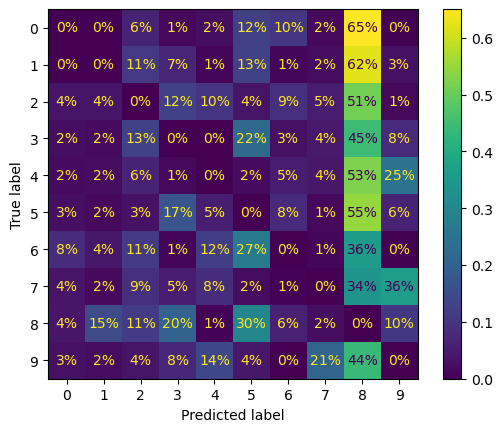

In [90]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                       sample_weight=sample_weight,
                                       normalize="true", values_format=".0%")

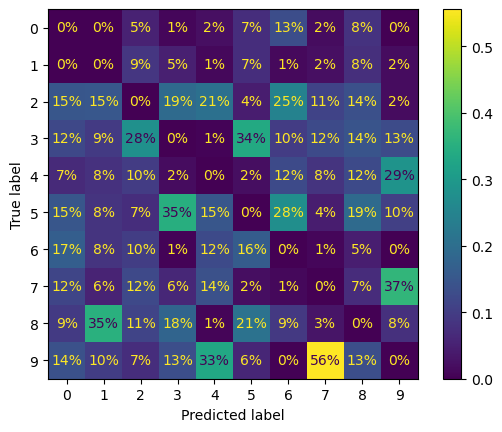

In [91]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                       sample_weight=sample_weight,
                                       normalize="pred", values_format=".0%")

In [92]:
cl_a, cl_b = "5", "8"
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

Text(0, 0.5, 'True label')

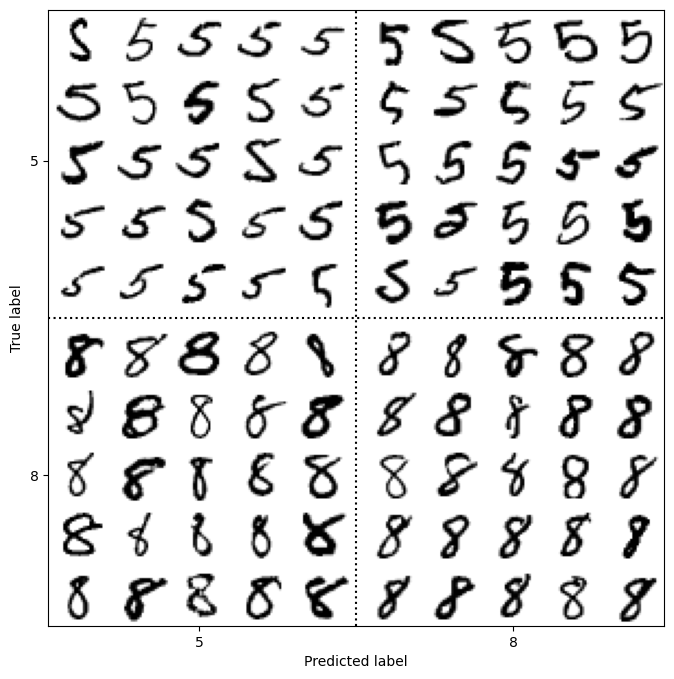

In [93]:
size = 5
pad = 0.2
plt.figure(figsize=(8,8))
for images, (label_col, label_row) in [(X_ba, (0,0)), (X_bb, (1,0)),
                                      (X_aa, (0,1)), (X_ab, (1,1))]:
  for idx, images_data in enumerate(images[:size*size]):
    x = idx % size + label_col * (size + pad)
    y = idx // size + label_row * (size + pad)
    plt.imshow(images_data.reshape(28,28), cmap="binary",
              extent=(x, x+1, y, y+1))
plt.xticks([size/2, size+pad+size/2], [str(cl_a), str(cl_b)])
plt.yticks([size/2, size+pad+size/2], [str(cl_b), str(cl_a)])
plt.plot([size+pad/2, size+pad/2], [0,2*size+pad], "k:")
plt.plot([0,2*size+pad], [size+pad/2, size+pad/2], "k:")
plt.axis([0,2*size+pad, 0, 2*size+pad])
plt.xlabel("Predicted label")
plt.ylabel("True label")

In [94]:
y_train_large = (y_train >= "7")
y_train_odd = (y_train.astype("int8")%2 == 1)
y_train_1 = (y_train == "1")
y_multilabel = np.c_[y_train_large, y_train_odd, y_train_1]

In [95]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [96]:
knn_clf.predict([some_digit])

array([[False,  True, False]])

In [97]:
knn_clf.predict([X_test[2]])

array([[False,  True,  True]])

In [98]:
y_test[2]

'1'

In [99]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)

In [100]:
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.9760616542026969

In [101]:
chain_clf = ClassifierChain(SVC(), cv=3, random_state=42)
chain_clf.fit(X_train[:2000], y_multilabel[:2000])

ClassifierChain(base_estimator=SVC(), cv=3, random_state=42)

In [102]:
chain_clf.predict([some_digit])

array([[0., 1., 0.]])

In [103]:
np.random.seed(42)
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [104]:
X_train.shape

(60000, 784)

Text(0.5, 1.0, 'Clean image')

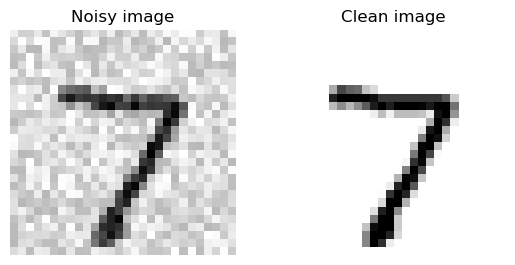

In [105]:
plt.subplot(1, 2, 1)
plt.imshow(X_test_mod[0].reshape(28,28), cmap="binary")
plt.axis("off")
plt.title("Noisy image")

plt.subplot(1, 2, 2)
plt.imshow(y_test_mod[0].reshape(28,28), cmap="binary")
plt.axis("off")
plt.title("Clean image")

In [106]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)

KNeighborsClassifier()

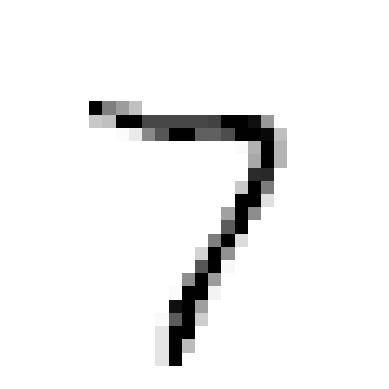

In [107]:
clean_digit = knn_clf.predict([X_test_mod[0]])
plot_digit(clean_digit)

In [108]:
y_train[:20]

array(['5', '0', '4', '1', '9', '2', '1', '3', '1', '4', '3', '5', '3',
       '6', '1', '7', '2', '8', '6', '9'], dtype=object)

In [109]:
some_digit.shape

(784,)

# Exercises

# 1

In [7]:
knn_clf = KNeighborsClassifier()

In [8]:
knn_clf.fit(X_train, y_train)

KNeighborsClassifier()

In [9]:
knn_clf.score(X_test, y_test)

0.9688

In [10]:
param_grid = [
  {"weights": ["uniform", "distance"],
  "n_neighbors": [4, 5, 6]}
]

knn_clf = KNeighborsClassifier()

In [11]:
grid_search = GridSearchCV(knn_clf, param_grid, cv=3,
                          scoring="accuracy")

In [12]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [4, 5, 6],
                          'weights': ['uniform', 'distance']}],
             scoring='accuracy')

In [13]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [14]:
grid_search.best_score_

0.9703500000000002

In [15]:
grid_search.score(X_test, y_test)

0.9714

In [16]:
pred = grid_search.predict(X_test)

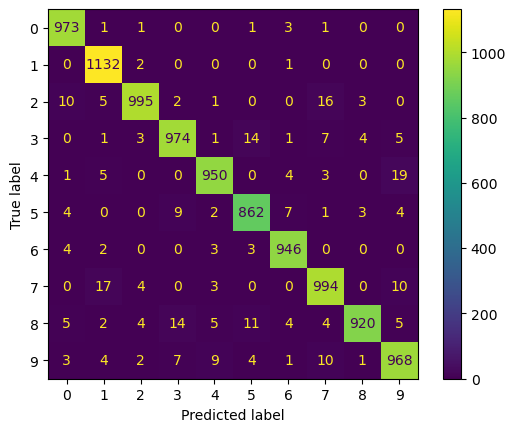

In [17]:
ConfusionMatrixDisplay.from_predictions(y_test, pred)

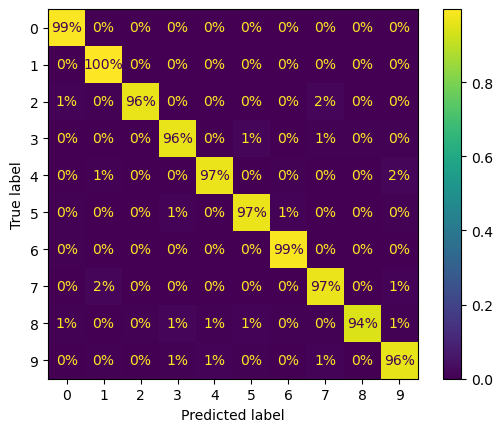

In [18]:
ConfusionMatrixDisplay.from_predictions(y_test, pred, normalize="true",
                                       values_format=".0%")

# 2

In [19]:
def shift_image(img, dx, dy):
  img = img.reshape((28,28))
  shifted_img = shift(img, [dx, dy], cval=0)
  
  return shifted_img.reshape([-1])

Text(0.5, 1.0, 'Original')

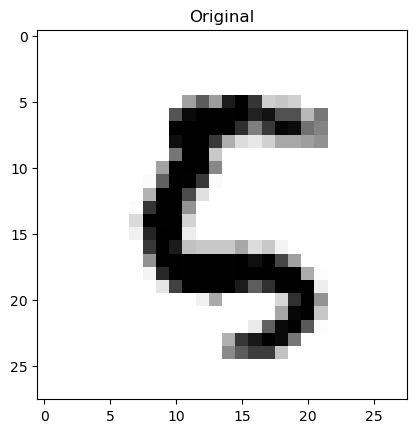

In [20]:
image = X_train[2000].reshape((28,28))

plt.imshow(image, cmap="binary")
plt.title("Original")

Text(0.5, 1.0, 'shifted up')

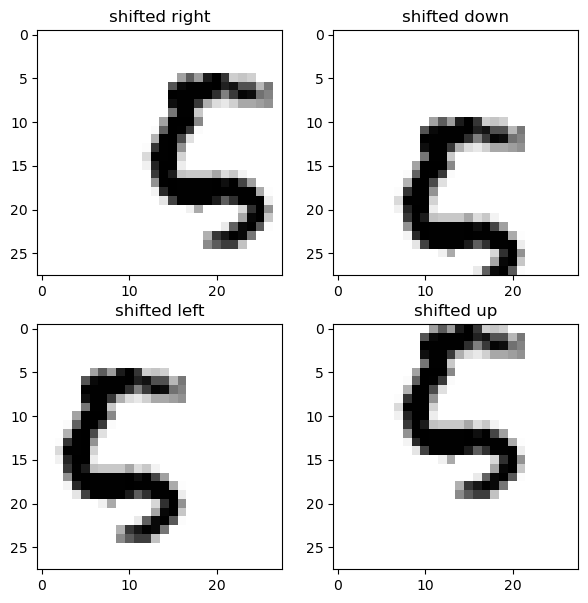

In [21]:
shifted_down = shift_image(image, 0, 5)
shifted_left = shift_image(image, 5, 0)
shifted_up = shift_image(image, 0, -5)
shifted_right = shift_image(image, -5, 0)

plt.figure(figsize=(7,7))

plt.subplot(221)
plt.imshow(shifted_down.reshape(28,28), cmap="binary")
plt.title("shifted right")

plt.subplot(222)
plt.imshow(shifted_left.reshape(28,28), cmap="binary")
plt.title("shifted down")

plt.subplot(223)
plt.imshow(shifted_up.reshape(28,28), cmap="binary")
plt.title("shifted left")

plt.subplot(224)
plt.imshow(shifted_right.reshape(28,28), cmap="binary")
plt.title("shifted up")

In [23]:
X_train_aug = [image for image in X_train]
y_train_aug = [label for label in y_train]

for dx, dy in ((0, 1), (1, 0), (0, -1), (-1, 0)):
  for img, lab in zip(X_train, y_train):
    X_train_aug.append(shift_image(img, dx, dy))
    y_train_aug.append(lab)


X_train_aug = np.array(X_train_aug)
y_train_aug = np.array(y_train_aug)

In [24]:
X_train_aug.shape

(300000, 784)

In [25]:
shuffle_idx = np.random.permutation(len(X_train_aug))

X_train_aug = X_train_aug[shuffle_idx]
y_train_aug = y_train_aug[shuffle_idx]

In [27]:
knn_clf = KNeighborsClassifier(**grid_search.best_params_)

In [28]:
knn_clf.fit(X_train_aug, y_train_aug)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [29]:
knn_clf.score(X_test, y_test)

0.9763